In [8]:
from funcs import *

In [9]:
install_pysddp()
file_path = './NewaveAugust2023/'

PySDDP is already installed.


In [10]:
try:
    PMOAGO2023 = configure_paths_and_read_data(file_path)
    print("Data has been read successfully.")
except FileNotFoundError as e:
    print(e)

OK! Leitura do CASO.DAT realizada com sucesso.
OK! Leitura do ARQUIVOS.DAT realizada com sucesso.
OK! Leitura do DGER.DAT realizada com sucesso.
OK! Leitura do HIDR.DAT realizada com sucesso.
OK! Leitura do VAZOES.DAT realizada com sucesso.
OK! Leitura do MODIF.DAT realizada com sucesso. ( 99 Usinas Hidraulicas Modificadas )
OK! Leitura do EXPH.DAT realizada com sucesso. ( 2 Usinas Hidraulicas Expandidas )
OK! Leitura do CONFHD.DAT realizada com sucesso.
OK! Leitura do REE.DAT realizada com sucesso. ( 12 Reservatórios Equivalentes de Energia Foram Lidos )
OK! Leitura do SISTEMA.DAT realizada com sucesso.
Data has been read successfully.


dict_keys(['codigo', 'nome', 'posto', 'ree', 'vol_ini', 'status', 'modif', 'ano_i', 'ano_f', 'bdh', 'sist', 'empr', 'jusante', 'desvio', 'vol_min', 'vol_max', 'vol_vert', 'vol_min_desv', 'cota_min', 'cota_max', 'pol_cota_vol', 'pol_cota_area', 'coef_evap', 'num_conj_maq', 'maq_por_conj', 'pef_por_conj', 'cf_hbqt', 'cf_hbqt_2', 'cf_hbqt_3', 'cf_hbqt_4', 'cf_hbqt_5', 'cf_hbqg', 'cf_hbqg_2', 'cf_hbqg_3', 'cf_hbqg_4', 'cf_hbqg_5', 'cf_hbpt', 'cf_hbpt_2', 'cf_hbpt_3', 'cf_hbpt_4', 'cf_hbpt_5', 'alt_efet_conj', 'vaz_efet_conj', 'prod_esp', 'perda_hid', 'num_pol_vnj', 'pol_vaz_niv_jus', 'pol_vaz_niv_jus_2', 'pol_vaz_niv_jus_3', 'pol_vaz_niv_jus_4', 'pol_vaz_niv_jus_5', 'cota_ref_nivel_jus', 'cfmed', 'inf_canal_fuga', 'fator_carga_max', 'fator_carga_min', 'vaz_min', 'unid_base', 'tipo_turb', 'repres_conj', 'teifh', 'ip', 'tipo_perda', 'data', 'observ', 'vol_ref', 'tipo_reg', 'vazoes', 'vol_mint', 'vol_maxt', 'vol_minp', 'vaz_mint', 'cmont', 'cfugat', 'vol_util', 'pot_efet', 'vaz_efet', 'status

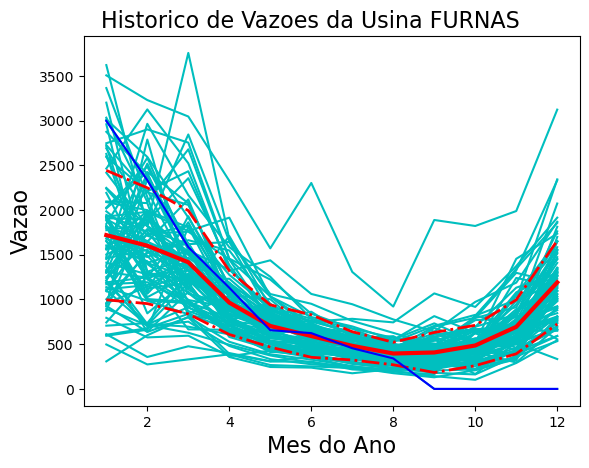

Aqui está a usina: Furnas


In [11]:
plant_name = 'Furnas'
Usina = visualize_plant_data(PMOAGO2023, plant_name)
print("Aqui está a usina:", Usina)

In [12]:
# Total de anos
total_anos = 6

# Número de anos considerados (excluindo 1931 e os últimos dois anos - 2022 e 2023)
num_anos = total_anos - 1

# Número de meses considerados (num_meses = num_phis)
num_meses = 5

# Número de phis considerados (num_meses = num_phis)
num_phis = 5

# Mês escolhido
mes = 3

In [13]:
from cvxopt import matrix, solvers
import numpy as np

def calculo_regressao_linear(Usina, mes, num_phis, imprime):

  #-----> Função Objetivo

  # Parte linear

  q = matrix(np.zeros(num_anos + num_phis))

  # Parte quadrática

  P = 2*np.eye(num_anos + num_phis)

  for i in range(num_phis):
    P[i][i] = 0


  P = matrix(P)

  #-----> Restrições de Igualdade

  # Função para o recorte das matrizes

  # def recorte(mes, nome):
  #   num_mes = mes - 1
  #   if (nome == 'Aeq'):
  #     recorte =  Usina['vazoes'][1:total_anos, num_mes-num_phis:num_mes]
  #     return recorte
  #   if (nome == 'Beq'):
  #     recorte = Usina['vazoes'][1:total_anos, num_mes:num_mes+1]
  #     return recorte

  def recorte(mes, nome):
    num_mes = mes - 1

    if (nome == 'Aeq'):
      if num_mes - num_phis >= 0:
        recorte =  Usina['vazoes'][1:total_anos, num_mes-num_phis:num_mes]
        recorte = recorte[:, ::-1]                               # Para espelhar a matriz e ficar com os dados de trás para frente
        return recorte
      else:
        recorte_ano_atual    =  Usina['vazoes'][1:total_anos, 0:num_mes]
        recorte_ano_atual = recorte_ano_atual[:, ::-1]           # Para espelhar a matriz e ficar com os dados de trás para frente

        recorte_ano_anterior =  Usina['vazoes'][0:total_anos-1, (num_mes-num_phis):]
        recorte_ano_anterior = recorte_ano_anterior[:, ::-1]     # Para espelhar a matriz e ficar com os dados de trás para frente

        recorte = matrix(np.concatenate((recorte_ano_atual, recorte_ano_anterior), axis=1))
        return recorte

    if (nome == 'Beq'):
      recorte = Usina['vazoes'][1:total_anos, num_mes:num_mes+1]
      return recorte

# if Mes_analisado - N_meses >= 0:

# recorteAnoAtual = Usina['vazoes'][1:N_anos+1,0:Mes_analisado]

# recorteAnoAnt = Usina['vazoes'][0:N_anos,(Mes_analisado-N_meses):]

# recorte = np.hstack((recorteAnoAnt,recorteAnoAtual))

  recorte_Aeq = recorte(mes, 'Aeq')
  matriz_id_1 = np.eye(num_anos)

  Aeq = matrix(np.concatenate((recorte_Aeq, matriz_id_1), axis=1))

  Beq = matrix(recorte(mes, 'Beq'))
  Beq = Beq*1.0


  #-----> Restrições de Canalização ( -inf < phi < inf  e  -inf < erro < inf)

  matriz_id_2 = np.eye(num_anos + num_phis)

  G = matrix(np.concatenate((-1*matriz_id_2, matriz_id_2), axis=0))

  h = list()
  for i in range(num_anos + num_phis):
    h.append(1e10)
    # h.append(np.inf)
  for i in range(num_anos + num_phis):
    h.append(1e10)
    # h.append(np.inf)
  h = matrix(h)

  # Imprime as informações das matrizes

  if imprime == True:
    print('P: ',P)
    print('q: ',q)
    print('G: ',G)
    print('h: ',h)
    print('Aeq: ',Aeq)
    print('Beq: ',Beq)
    print(' ')
    print('Type P: ',type(P))
    print('Type q: ',type(q))
    print('Type G: ',type(G))
    print('Type h: ',type(h))
    print('Type Aeq: ',type(Aeq))
    print('Type Beq: ',type(Beq))
    print(' ')
    print('Tamanho P: ',np.shape(P))
    print('Tamanho q: ',np.shape(q))
    print('Tamanho G: ',np.shape(G))
    print('Tamanho h: ',np.shape(h))
    print('Tamanho Aeq: ',np.shape(Aeq))
    print('Tamanho Beq: ',np.shape(Beq))

  # Resolve o Problema de Otimização Quadrática

  solvers.options['show_progress'] = False

  sol = solvers.qp(P, q, G, h, Aeq, Beq)

  resultados = sol['x']

  return resultados

In [14]:
resultado = calculo_regressao_linear(Usina, mes, num_phis, imprime=False)

TypeError: string indices must be integers